# Predicting heart rate during excercise with LSTM

Training an LSTM model to predict heart rate in n seconds in future based on the sensor measurements over the past 60 seconds. The data is collected from Garmin Fenix 6s during running excercises, performed by the author, mostly in a hilly environment. The fit files data was converted into csv files with fitdecode library https://github.com/polyvertex/fitdecode. Fit-files format is used at least by Garmin and Suunto devices.

Some of the useful inputs available for cycling or running include:
- heart rate
- cadence
- speed
- altitude
- grade 
- power
- distance

In [1]:
# load libraries
import os, glob 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras

# location of the fit files
fit_path = "/home/riku/projects/athlet_hr_predict/fit_file_csv"
os.chdir(fit_path)




In [2]:
# add calculated altitude difference column, and 5sec moving average column. Remove geographical coordinates for privacy.
fit_files = glob.glob("*.csv")
for file in fit_files:
    df = pd.read_csv(fit_path+'/'+file, index_col='timestamp')
    df['alt_difference'] = df['enhanced_altitude'] - df['enhanced_altitude'].shift(1)
    df['rolling_ave_alt'] = df['alt_difference'].rolling(window=5).mean()
    df = df.bfill()
    df = df.drop(['position_lat','position_long'], axis=1, errors='ignore')
    df.to_csv(fit_path+'/'+file)


In [3]:
# set parameters, file names

#select the features for EDA graphs:
eda_model_features =  ["heart_rate", "enhanced_speed","rolling_ave_alt", "cadence", "distance", "enhanced_altitude"] #  cadence, enhanced_altitude, distance, heart_rate, enhanced_speed, rolling_ave_alt

#select the predictors for the model:
model_features =  ["heart_rate", "enhanced_speed","rolling_ave_alt"] #  cadence, altitude, distance, heart_rate, enhanced_speed, rolling_ave_alt

n_X = 60 # number of timesteps for training
n_y = 20 # number of timesteps in future for prediction
step = 1 # step size of predictors for model training
batch_size = 60 # training batch size for the LSTM
epochs = 100 # maximum number of epochs - autostop will work on per file basis
learning_rate = 0.002
sequence_length = int(n_X/step)
n_fit_files_test_set = 1 # number of files for validation dataset (only 1 validation file supported at the moment)

# select the training files and the validation files 
train_files = glob.glob("*.csv")[0:-n_fit_files_test_set]
valid_files = glob.glob("*.csv")[-n_fit_files_test_set:]

In [4]:
# calculate the data normalisation parameters from all training data

def normalize(data):
    data_mean = data.mean(axis=0)
    data_std = data.std(axis=0)
    #return (data - data_mean) / data_std, data_mean, data_std
    return data_mean, data_std

li = []

for file in train_files:
    df = pd.read_csv(fit_path+'/'+file, index_col='timestamp')[model_features]
    li.append(df)

df = pd.concat(li, axis=0, ignore_index=True)

df_mean, df_std = normalize(df)

def denormalize_hr(data):
    return data*df_std[0]+df_mean[0] 

## Short EDA

Selected features are shown on the plots. The fit file here was collected during a hilly 5km run. It shows large variability during the workout in heart rate, speed and altitude. Cadence is relatively constant throughout the excercise.

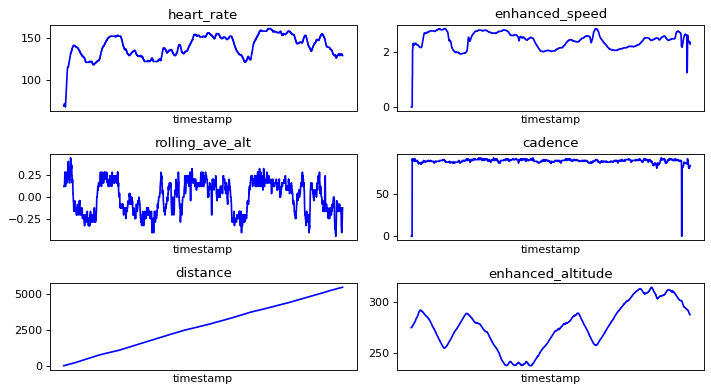

In [5]:
eda_example = pd.read_csv(fit_path+'/RUN_2021-08-26-07-15-23.fit.csv', index_col='timestamp')[eda_model_features]

def show_raw_visualization(data):
    time_data = data.index
    fig, axes = plt.subplots(
        nrows=int(len(eda_model_features)/2+0.5), ncols=2, figsize=(9, 5), dpi=80, facecolor="w", edgecolor="k"
    )
    for i in range(len(eda_model_features)):
        key = eda_model_features[i]
        t_data = data[key]
        t_data.index = time_data
        t_data.head()
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            color='b',
            title="{}".format(key),
            rot=25,
        )
        ax.set_xticks([])
    plt.tight_layout()

show_raw_visualization(eda_example)


## Create validation dataset

In [6]:
# validation dataset - train each file at the time

for file in train_files:
    df = pd.read_csv(fit_path+'/'+file, index_col='timestamp')[model_features]
    df = (df - df_mean) / df_std
    start = n_X + n_y
    end = n_X + len(df.index)
    
    x = df[model_features].values
    y = df.iloc[start:end][["heart_rate"]]
    
    dataset_val = keras.preprocessing.timeseries_dataset_from_array(
        x,
        y,
        sequence_length=sequence_length,
        sampling_rate=step,
        batch_size=batch_size,
    )

2021-09-15 11:41:39.542237: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-15 11:41:39.546037: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-15 11:41:39.546325: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-15 11:41:39.546785: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

## Build the model

In [7]:
# get the shapes of X & y for a batch
for batch in dataset_val.take(1):
    inputs, targets = batch

# the model
inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
#lstm_out = keras.layers.LSTM(4, return_sequences=True)(inputs)
lstm_out = keras.layers.LSTM(4)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model.summary()

path_checkpoint = "model_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)


2021-09-15 11:41:40.370192: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 60, 3)]           0         
_________________________________________________________________
lstm (LSTM)                  (None, 4)                 128       
_________________________________________________________________
dense (Dense)                (None, 1)                 5         
Total params: 133
Trainable params: 133
Non-trainable params: 0
_________________________________________________________________


## Load the training data, train the model file by file

Each file is processed separately, and training epochs repeated as long as the model improves for each model up to the variable $epochs$ defined earlier. 

In [8]:
# training dataset, and train each file at the time

def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

for file in train_files:
    df = pd.read_csv(fit_path+'/'+file, index_col='timestamp')[model_features]
    df = (df - df_mean) / df_std
    print(file)
    start = n_X + n_y
    end = n_X + len(df.index)
    
    x = df[model_features].values
    y = df.iloc[start:end][["heart_rate"]].values
    
    dataset_train = keras.preprocessing.timeseries_dataset_from_array(
        x,
        y,
        sequence_length=sequence_length,
        sampling_rate=step,
        batch_size=batch_size,
    )
    
    history = model.fit(
        dataset_train,
        epochs=epochs,
        validation_data=dataset_val,
        callbacks=[es_callback, modelckpt_callback],
        verbose=0
    )

    #visualize_loss(history, "Training and Validation Loss")


RUN_2021-09-01-09-09-44.fit.csv


2021-09-15 11:41:41.872353: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8100



Epoch 00001: val_loss improved from inf to 1.51195, saving model to model_checkpoint.h5

Epoch 00002: val_loss improved from 1.51195 to 1.19432, saving model to model_checkpoint.h5

Epoch 00003: val_loss improved from 1.19432 to 0.99658, saving model to model_checkpoint.h5

Epoch 00004: val_loss improved from 0.99658 to 0.85596, saving model to model_checkpoint.h5

Epoch 00005: val_loss improved from 0.85596 to 0.74678, saving model to model_checkpoint.h5

Epoch 00006: val_loss improved from 0.74678 to 0.65435, saving model to model_checkpoint.h5

Epoch 00007: val_loss improved from 0.65435 to 0.59071, saving model to model_checkpoint.h5

Epoch 00008: val_loss improved from 0.59071 to 0.55150, saving model to model_checkpoint.h5

Epoch 00009: val_loss improved from 0.55150 to 0.52480, saving model to model_checkpoint.h5

Epoch 00010: val_loss improved from 0.52480 to 0.50658, saving model to model_checkpoint.h5

Epoch 00011: val_loss improved from 0.50658 to 0.49231, saving model to m

## Visualise the training for the last file

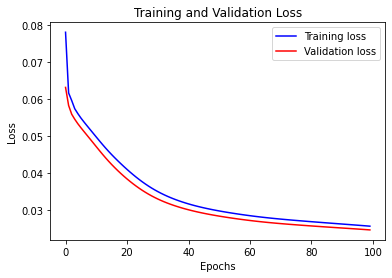

In [9]:
visualize_loss(history, "Training and Validation Loss")

## Check the model predictions visually

In [10]:
    # create test set from a file not used for training or validation during the parameters tuning
    
    df_test = pd.read_csv(fit_path+'/../RUN_2021-08-05-11-12-41.fit.csv', index_col='timestamp')[model_features]
    df_test = (df_test - df_mean) / df_std
   
    x = df_test[model_features].values
    y = df_test.iloc[start:end][["heart_rate"]].values

    dataset_test = keras.preprocessing.timeseries_dataset_from_array(
    x,
    y,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=120)



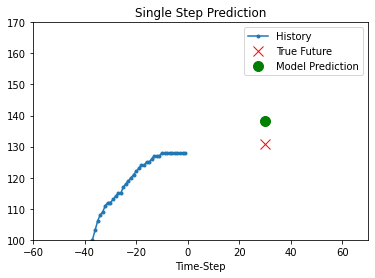

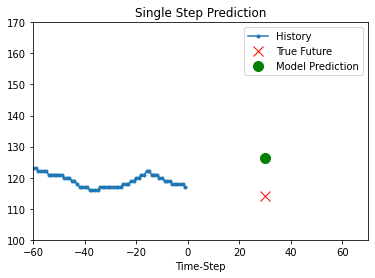

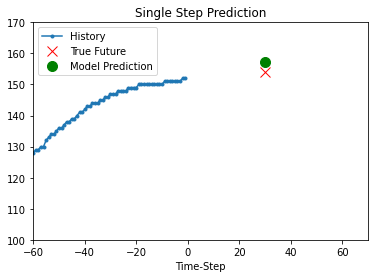

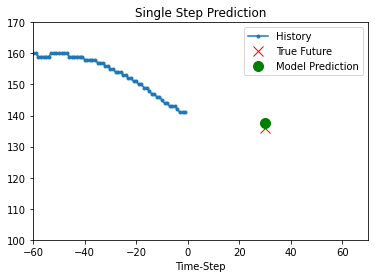

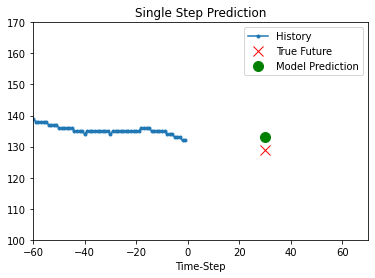

In [11]:


def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))

    if delta:
        future = delta
    else:
        future = 0
    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.ylim(100,170)
    plt.xlabel("Time-Step")
    plt.show()
    return


for x, y in dataset_test.take(5):
    show_plot(
        [denormalize_hr(x[0][:, 0].numpy()), denormalize_hr(y[0]), denormalize_hr( model.predict(x)[0])],
        30,
        "Single Step Prediction",
    )

## Model evaluation 

under construction

In [17]:
# create test set from a file not used for training or validation during the parameters tuning

df_test = pd.read_csv(fit_path+'/../RUN_2021-08-05-11-12-41.fit.csv', index_col='timestamp')[model_features]
df_test = (df_test - df_mean) / df_std

x = df_test[model_features].values
y = df_test.iloc[start:end][["heart_rate"]].values

dataset_test = keras.preprocessing.timeseries_dataset_from_array(
x,
y,
sequence_length=sequence_length,
sampling_rate=step,
batch_size=1)

# turn it into dataframe with observed & predicted values for test set comparison
d=pd.DataFrame([0,1])
for x, y in dataset_test:
    a = denormalize_hr(y[0]).numpy(), denormalize_hr( model.predict(x)[0])
    c = pd.DataFrame(a).T
    d = d.merge(c, how='outer')
d.columns=['measured', 'predicted']
d = d.bfill()

<AxesSubplot:xlabel='Timestep', ylabel='HR'>

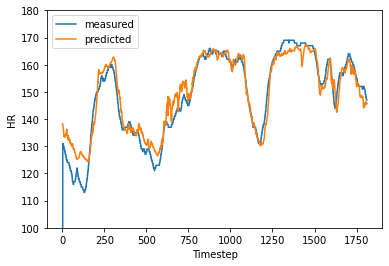

In [18]:
# time domain plot with observed blue, and predicted orange. Predicted is calculated values where previous 30sec of inputs are missing.

d.plot(ylim=(100,180), xlabel='Timestep', ylabel='HR')


In [19]:
# calculate some stats
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import scipy

y_test, pred_test = d['measured'].values,d['predicted'].values

MSE_test=round(mean_squared_error(y_test, pred_test, squared=True),3)
MAE_test=round(mean_absolute_error(y_test, pred_test),3)

test_sdev = np.std(pred_test-y_test)*1.96
test_mean = np.mean(pred_test-y_test)
print ('Prediction interval {} +/- {}'.format(test_mean,test_sdev))

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h, h

mean_s, ci95_l, ci95_h, mean_uncertainty = mean_confidence_interval(data=(pred_test-y_test))


Prediction interval 1.1873314206963343 +/- 12.232362820645166


/home/riku/miniconda3/envs/hrpredict/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


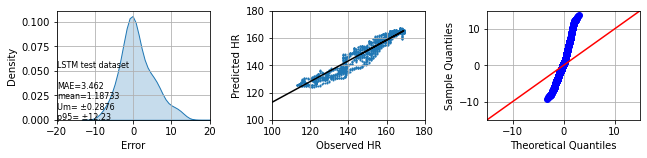

In [23]:
# graph the model performance

import seaborn as sns
import statsmodels.api as sm

m, b = np.polyfit(y_test, pred_test, 1)

fig, ((ax1, ax2, ax3)) = plt.subplots(1,3)
fig.set_size_inches(9, 2.3)
sns.kdeplot( x=pred_test-y_test, fill=True, ax=ax1, common_norm=False)
ax2.scatter(x=y_test, y=pred_test, s=1)
ax2.plot(y_test, m*y_test + b, c='black')
sm.qqplot((pred_test-y_test), line ='45', ax=ax3)

ax1.set_xlim(-20,20)
ax1.set_xlabel('Error')
ax2.set_xlabel('Observed HR')
ax2.set_ylabel('Predicted HR')
ax2.set_xlim(100,180)
ax2.set_ylim(100,180)
ax3.set_xlim(-15,15)
ax3.set_ylim(-15,15)
ax1.text(-19.8,0.0,'LSTM test dataset\n' + '\nMAE='+str(MAE_test) + "\nmean="+ str(round(mean_s,5)) + "\nUm= ±"+ str(round(mean_uncertainty,4))+'\np95= ±'+ str(round(test_sdev,2)) , fontsize=8 )
ax1.grid()
ax2.grid()
ax3.grid()
plt.tight_layout()
plt.show()


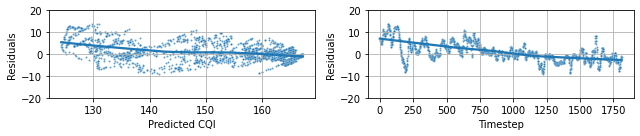

In [21]:
# further residuals plots
import random
fig, ((ax1, ax2)) = plt.subplots(1,2)
fig.set_size_inches(9, 2)

y_pred_error = (pred_test - y_test)
x_n = np.arange(0,len(y_pred_error))

sns.regplot(x=pred_test, y=y_pred_error, scatter=False,  ax=ax1, ci=95, lowess=True)
sns.regplot(x=x_n, y=y_pred_error, scatter=False,  ax=ax2, ci=95, lowess=True)
sns.scatterplot(x=pred_test, y=y_pred_error,  ax=ax1, alpha = 0.7, s=4)
sns.scatterplot(x=x_n, y=y_pred_error,  ax=ax2, alpha = 0.7, s=4)

ax2.set_ylim(-20,20)
ax1.set_ylim(-20,20)
ax2.set_xlabel('Timestep')
ax2.set_ylabel('Residuals')
ax1.set_xlabel('Predicted CQI')
ax1.set_ylabel('Residuals')
ax1.grid()
ax2.grid()
plt.tight_layout()
plt.show()